In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
import warnings
import matplotlib.pyplot as plt

In [134]:
import numpy as np
import glob
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = 100
mpl.rcParams['figure.dpi'] = dpi
sns.set_context("notebook")

import pandas as pd
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *

### Load in data

In [135]:
savedir = "/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/data/model/"

In [136]:
ds = xr.open_dataset(
        datadir("/model/Global_WMT_Budget.nc"))
ds["BF_Adv"] = ds["surface_ocean_flux_advective_negative_rhs"]
ds["BF_NonAdv"] = ds["boundary_fluxes"] - ds["BF_Adv"]

ds["surface_boundary_fluxes"] = ds["boundary_fluxes"] - ds["bottom_flux_heat"]

ds["boundary_fluxes_heat"] = ds["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds["surface_exchange_flux_heat"] +\
                                 ds["frazil_ice_heat"] + ds["bottom_flux_heat"]

ds["boundary_fluxes_salt"] = ds["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds["surface_exchange_flux_salt"]
ds["other_bf_terms"] = ds["boundary_fluxes"] - (ds["surface_ocean_flux_advective_negative_rhs_salt"] + ds["surface_exchange_flux_heat"])

ds["other_plot_terms"] = ds["mass_source"] + ds["other_bf_terms"]

### Extract water mass budget

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\geq + \mathcal{S}_\geq + \Psi_\geq + \mathcal{G}^{BF}_\geq + \mathcal{G}^{Mix}_\geq + \mathcal{G}^{Spurious}_\geq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\geq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\geq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\geq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\geq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\geq$.
- $\mathcal{G}^{BF}_\geq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\geq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\geq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


In [137]:
toTg = 1e-9 

mass_flux_units = "Tg/s"
mass_flux_units_conversion = toTg #kg to Tg 

In [138]:
integrate = lambda dx: np.cumsum(np.concatenate([[0], dx.values]))

In [139]:
experiments = ['forced', 'control']
nexpt = len(experiments)
ds["bf_other_terms"] = ds["boundary_fluxes_heat"] + ds["boundary_fluxes_salt"] - (ds["surface_exchange_flux_heat"] + ds["surface_ocean_flux_advective_negative_rhs_salt"])

budgets = ['mass_tendency', 
           'surface_boundary_fluxes',
           # 'surface_ocean_flux_advective_negative_rhs_salt',
           'diffusion', 
           'spurious_numerical_mixing',
           "bottom_flux_heat",
           ]

budgets_labels = [r"$\partial_{t} \mathcal{M}_\geq$", 
                  r"$\mathcal{G}^{SFC}_\geq$",
                  r"$\mathcal{G}^{mix}_\geq$",
                  r"$\mathcal{G}^{Spu}_\geq$",
                  r"$\mathcal{G}^{\theta_{BOT}}_\geq$", 
                  ]
times = [("2050", "2100")]

alphas = [1, 0.4, 0.4, 0.4, 1, 0.4]
ncols = len(times)

expt_colors = dict(); expt_colors["control"] = "#2f74b3"; expt_colors["forced"] = "#cc415a"

# Define the muted color palette
palette = sns.color_palette("tab10", len(budgets))

# Manually pick muted purple and brown from the palette
muted_purple = sns.color_palette("muted")[4]  # Approximate purple in "muted"
muted_brown = sns.color_palette("muted")[5]   # Approximate brown in "muted"

# Define custom colors for specific budgets
custom_colors = {
    "mass_tendency": muted_purple,
    "convergent_mass_transport": muted_brown,
}

# Generate colors for remaining variables
remaining_budgets = [budget for budget in budgets if budget not in custom_colors]
remaining_palette = sns.color_palette("muted", len(remaining_budgets))
remaining_colors = {budget: remaining_palette[i] for i, budget in enumerate(remaining_budgets)}

# Combine the custom colors and remaining colors into one dictionary
var_colors = {**custom_colors, **remaining_colors}

[None, None]

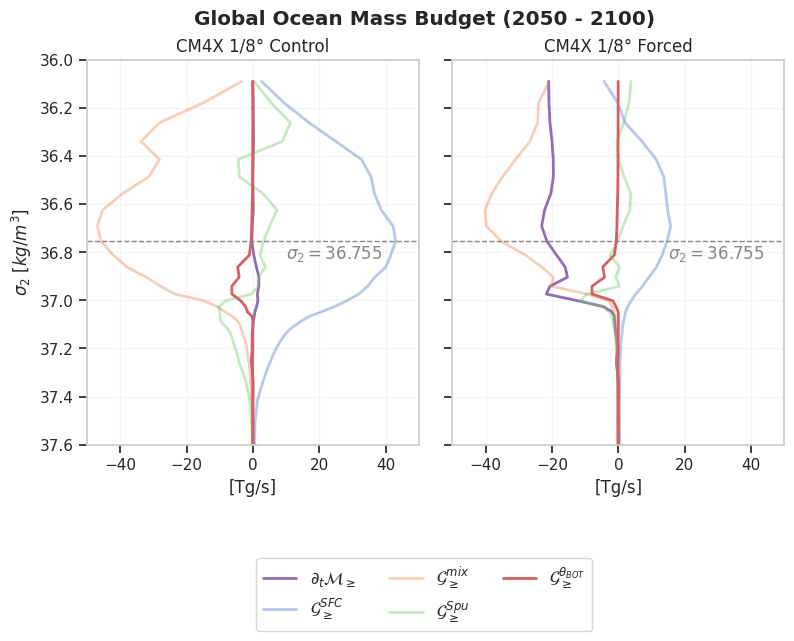

In [140]:
times = [("2050", "2100")]
ds_mean = ds.sel(time = slice(times[0][0], times[0][1])).mean("time")
ds_mean = ds_mean.sel(sigma2_l_target = slice(36, None))
sig_source_idx_max = ds_mean.sel(exp = "control")["surface_boundary_fluxes"].argmax()
sig_source_max = ds_mean.sigma2_l_target[sig_source_idx_max].values
sig_source_max = np.round(float(sig_source_max), decimals=3).item()

fig, ax = plt.subplots(1, 2, figsize = (9, 5),sharey = True, sharex = True)
fig.suptitle("Global Ocean Mass Budget (2050 - 2100)", fontweight = "bold")
for (i, exp) in enumerate(budgets):
    ax[1].set_title("CM4X 1/8° Forced")
    ax[1].plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")[exp], 
               ds_mean.sigma2_l_target, 
               label = budgets_labels[i], lw = 2.0,alpha = alphas[i], 
              c = var_colors[exp])
    ax[0].set_title("CM4X 1/8° Control")
    ax[0].plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")[exp], 
               ds_mean.sigma2_l_target,
               # label = budgets_labels[i], 
               lw = 2.0,alpha = alphas[i], 
              c = var_colors[exp])
x_off = [0, 5]
for (i, a) in enumerate(ax):
    a.axhline(sig_source_max, c = "grey", alpha = 0.95, lw = 1, linestyle = "--")
    a.annotate(r"$\sigma_2 = " + f"{sig_source_max}$", xy=(10. + x_off[i], sig_source_max + 0.05), fontsize = 12,
                      xytext=(0, 0), textcoords="offset points",
                      va="center", c = "grey", alpha = 0.95)
    a.tick_params(bottom=True, left=True)
# ax[0].legend()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize = 12)
fig.subplots_adjust(wspace = 0.1)
ax[0].set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
[a.set_xlabel("[Tg/s]") for a in ax]
ax[1].set_ylim(36, 37.6)
ax[1].set_xlim(-50, 50)
ax[1].invert_yaxis()
[a.grid(alpha = 0.2) for a in  ax]
# fig.savefig(plotsdir("paper_figures/Mass_Budget_Profile_Budget.png"), dpi = 200, bbox_inches = "tight")

[None, None]

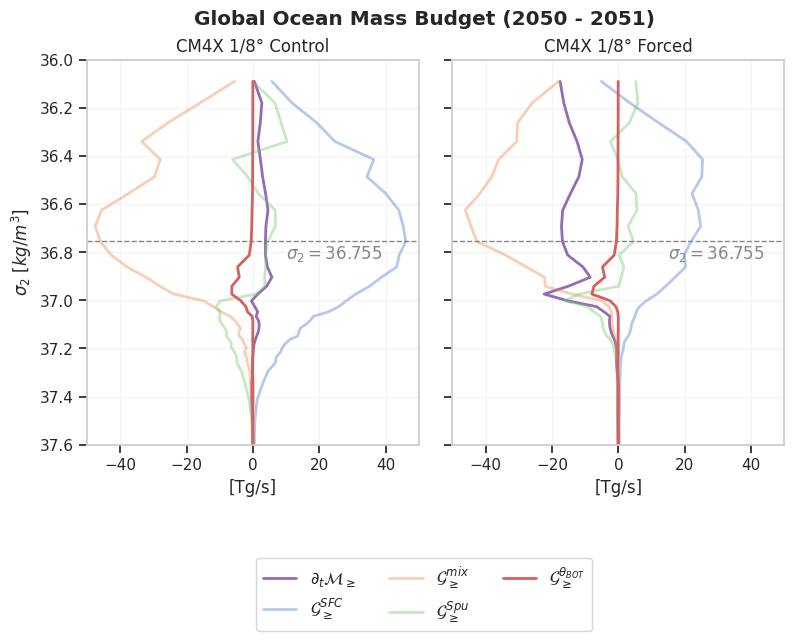

In [141]:
times = [("2050", "2051")]
ds_mean = ds.sel(time = slice(times[0][0], times[0][1])).mean("time")
ds_mean = ds_mean.sel(sigma2_l_target = slice(36, None))
sig_source_idx_max = ds_mean.sel(exp = "control")["surface_boundary_fluxes"].argmax()
sig_source_max = ds_mean.sigma2_l_target[sig_source_idx_max].values
sig_source_max = np.round(float(sig_source_max), decimals=3).item()

fig, ax = plt.subplots(1, 2, figsize = (9, 5),sharey = True, sharex = True)
fig.suptitle(f"Global Ocean Mass Budget ({times[0][0]} - {times[0][1]})", fontweight = "bold")
for (i, exp) in enumerate(budgets):
    ax[1].set_title("CM4X 1/8° Forced")
    ax[1].plot(mass_flux_units_conversion * ds_mean.sel(exp = "forced")[exp], 
               ds_mean.sigma2_l_target, 
               label = budgets_labels[i], lw = 2.0,alpha = alphas[i], 
              c = var_colors[exp])
    ax[0].set_title("CM4X 1/8° Control")
    ax[0].plot(mass_flux_units_conversion * ds_mean.sel(exp = "control")[exp], 
               ds_mean.sigma2_l_target,
               # label = budgets_labels[i], 
               lw = 2.0,alpha = alphas[i], 
              c = var_colors[exp])
x_off = [0, 5]
for (i, a) in enumerate(ax):
    a.axhline(sig_source_max, c = "grey", alpha = 0.95, lw = 1, linestyle = "--")
    a.annotate(r"$\sigma_2 = " + f"{sig_source_max}$", xy=(10. + x_off[i], sig_source_max + 0.05), fontsize = 12,
                      xytext=(0, 0), textcoords="offset points",
                      va="center", c = "grey", alpha = 0.95)
    a.tick_params(bottom=True, left=True)
# ax[0].legend()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize = 12)
fig.subplots_adjust(wspace = 0.1)
ax[0].set_ylabel(r"$\sigma_2$" + " " + r"$[kg/m^3]$")
[a.set_xlabel("[Tg/s]") for a in ax]
ax[1].set_ylim(36, 37.6)
ax[1].set_xlim(-50, 50)
ax[1].invert_yaxis()
[a.grid(alpha = 0.2) for a in  ax]
# fig.savefig(plotsdir("paper_figures/Mass_Budget_Profile_Budget.png"), dpi = 200, bbox_inches = "tight")

In [142]:
# sigma = 37.00
sigma = sig_source_max
times = [("2050", "2100")]

### Spatial patterns of advection and tendency terms

In [143]:
ds_sfc = xr.open_dataset("/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/model/Global_Surface_Advection_and_Tendency_sigma_36.775.nc")

In [144]:
ds_sfc["surface_ocean_flux_advective_negative_rhs"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_heat"] + ds_sfc["surface_ocean_flux_advective_negative_rhs_salt"]
ds_sfc["BF_Adv"] = ds_sfc["surface_ocean_flux_advective_negative_rhs"]
ds_sfc["BF_NonAdv"] = ds_sfc["boundary_fluxes"] - ds_sfc["BF_Adv"]

ds_sfc["surface_boundary_fluxes"] = ds_sfc["boundary_fluxes"] - ds_sfc["bottom_flux_heat"]

ds_sfc["boundary_fluxes_heat"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_heat"] +\
                                 ds_sfc["surface_exchange_flux_heat"] +\
                                 ds_sfc["frazil_ice_heat"] + ds_sfc["bottom_flux_heat"]

ds_sfc["boundary_fluxes_salt"] = ds_sfc["surface_ocean_flux_advective_negative_rhs_salt"] +\
                                 ds_sfc["surface_exchange_flux_salt"]

ds_sfc["diffusion"] = ds_sfc["diffusion_salt"] +  ds_sfc["diffusion_heat"]

# ds_sfc["spurious_mixing_psi_ratio"] = ds_sfc["spurious_numerical_mixing"].where((ds_sfc["spurious_numerical_mixing"] != 0.0) / \
#                                       ds_sfc["convergent_mass_transport"].where((ds_sfc["convergent_mass_transport"] != 0.0)

In [145]:
mass_flux_units_conversion = toTg / (ds_sfc.areacello / (100e3 **2 ))
mass_flux_units = r"$Tg/100^2 km^2 / s$"

In [146]:
import matplotlib.patches as  mpath
from matplotlib.colors import BoundaryNorm, ListedColormap
import cartopy.feature as cfeature

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def plot_antarctic_plot(ds, ax, cmap = None, norm = None, 
                        exp = "forced", variable = "mass_tendency", mass_flux_units_conversion = 1):

    wmt_mean_budget =  mass_flux_units_conversion * ds.sel(exp = exp)[variable]
    # wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    wmt_mean_budget = wmt_mean_budget.where(np.abs(wmt_mean_budget) > 1e-8)
    cm = ax.pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, transform=ccrs.PlateCarree(), 
                        norm = norm)
    ax.coastlines();
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')

    # Draw meridian lines with labels around circular boundary
    gls = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, \
                    xlocs=range(-180,171,45), ylocs=range(-90,0,10), \
                    color='gray', alpha=0.25, linestyle='-', zorder=10, 
                    xlabel_style = {"fontsize":9.5})

    
    ax.set_boundary(circle, transform=ax.transAxes)

    return cm

def plot_global_plot(ds, ax, cmap = None, norm = None, 
                        exp = "forced", variable = "mass_tendency", mass_flux_units_conversion = 1):

    wmt_mean_budget =  mass_flux_units_conversion * ds.sel(exp = exp)[variable]
    wmt_mean_budget = wmt_mean_budget.where(wmt_mean_budget != 0.0)
    wmt_mean_budget = wmt_mean_budget.where(np.abs(wmt_mean_budget) > 1e-8)
    cm = ax.pcolormesh(wmt_mean_budget.geolon, wmt_mean_budget.geolat, 
                         wmt_mean_budget, cmap = cmap, transform=ccrs.PlateCarree(), 
                        norm = norm)
    ax.coastlines();
    
    return cm

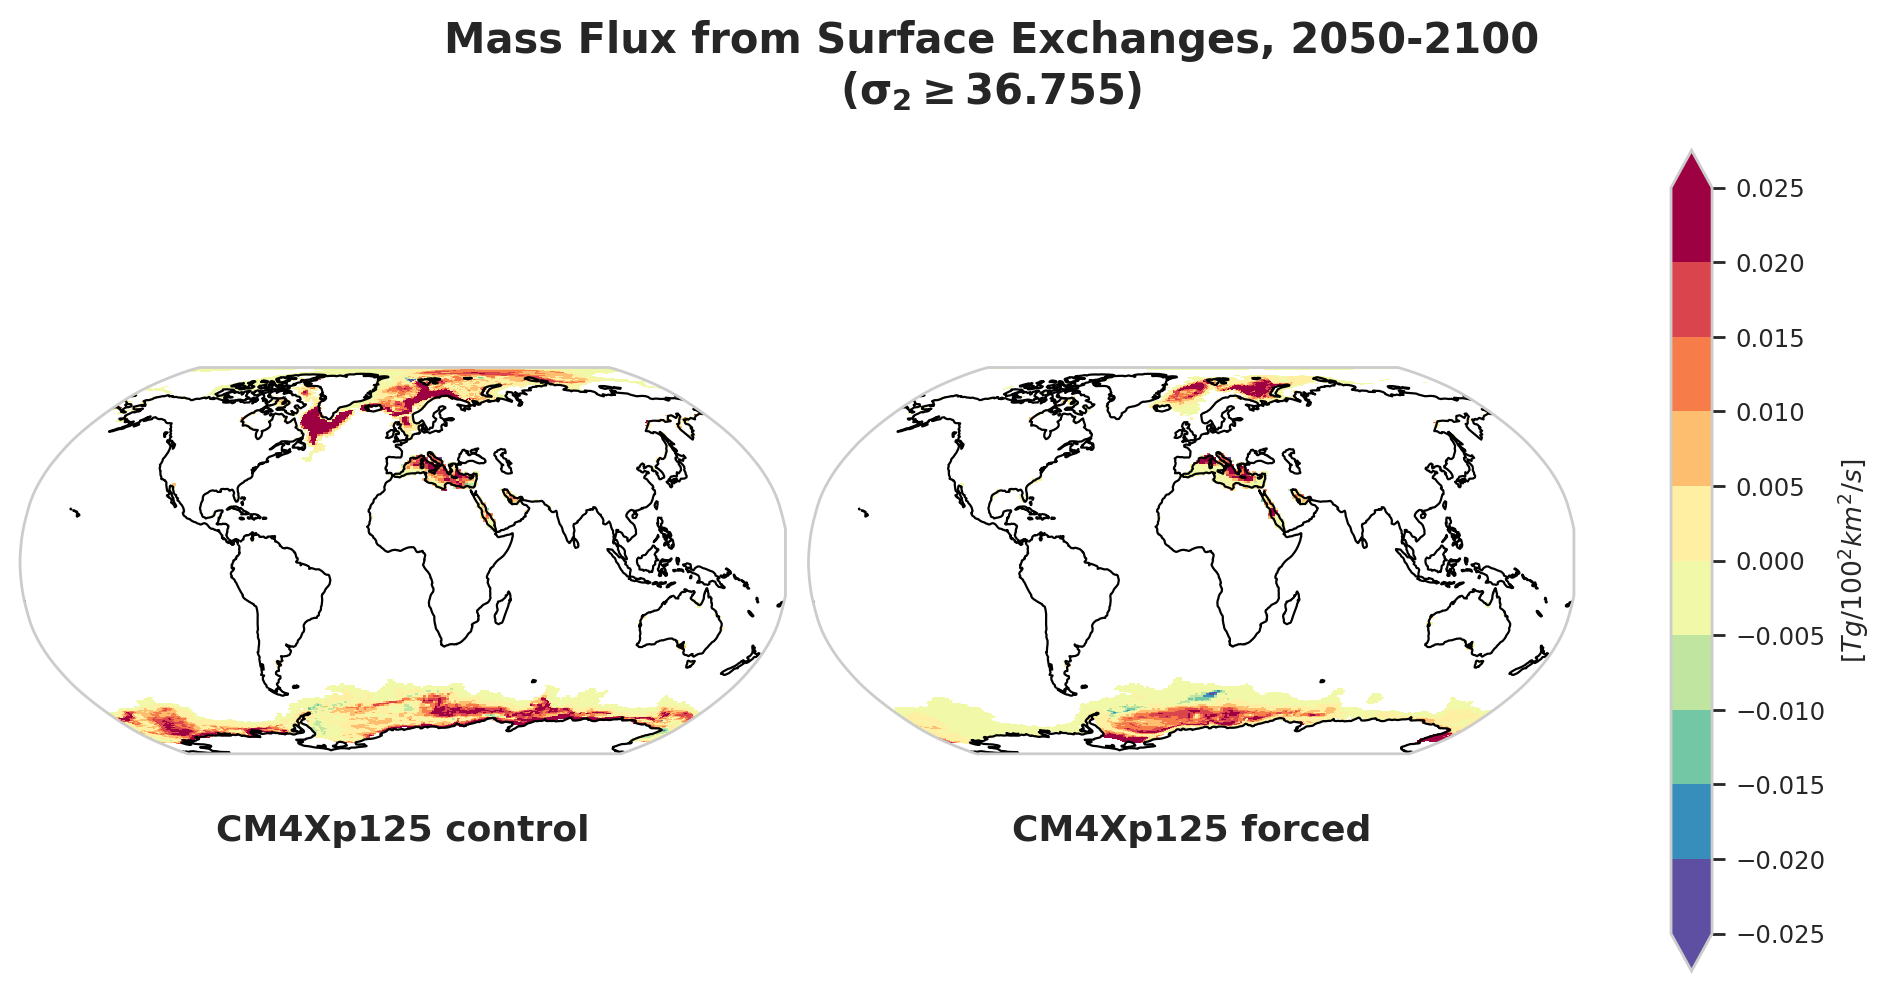

In [149]:
experiments = ['control', 'forced']
nexpt = len(experiments)
sns.set_style("whitegrid")
sns.set_context("paper")
mpl.rcParams['figure.dpi'] = 200

density_title = r"$\mathbf{(\sigma_2 \geq 36.755)}$"
cmap = plt.get_cmap('Spectral_r')
# boundaries = np.arange(-0.02, 0.0201, 0.005)
# boundaries = np.arange(-0.05, 0.0501, 0.01)
boundaries = np.arange(-0.05, 0.0501, 0.01) / 2

boundaries[np.abs(boundaries) < 1e-16]  = 0
norm = BoundaryNorm(boundaries, ncolors=cmap.N, clip=False)

# fig, ax = plt.subplots(1, 2, figsize = (10, 5),
#                         subplot_kw={'projection': ccrs.SouthPolarStereo()})


fig, ax = plt.subplots(1, 2, figsize = (10, 5),
                        subplot_kw={'projection': ccrs.Robinson()})
cmap = "Spectral_r"
width = 0.25
times = ("2050", "2100")
wmt_mean = ds_sfc.sel(time = slice(times[0], times[1])).mean("time")
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    cm = plot_global_plot(wmt_mean, ax[i], cmap = cmap, norm = norm, 
                       exp = exp, variable = "surface_boundary_fluxes", 
                        mass_flux_units_conversion = mass_flux_units_conversion)
fig.suptitle("Mass Flux from Surface Exchanges, " + '-'.join(times) + "\n" + density_title, 
             fontweight = "bold", fontsize = 15)


fig.tight_layout()

for a, row in zip(ax, experiments):
    a.annotate("CM4Xp125 " + row, xy=(0.5, -0.2), xytext=(-0, 0),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=13, ha='center', va='center', fontweight = "bold")
    
fig.colorbar(cm, ax = ax[:], label = f"[{mass_flux_units}]", extend = "both", 
             ticks=boundaries, orientation = "vertical")